In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys

sys.path.append('/data/yosef2/users/chenling/scVI/')
import scvi
scvi.__version__

import os
os.getcwd()

import logging
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from hyperopt import hp

from scvi.inference import UnsupervisedTrainer, AlternateSemiSupervisedTrainer
from scvi.models import VAE, SCANVI

from scvi.dataset.anndataset import AnnDatasetFromAnnData
import scanpy as sc
from anndata import read_h5ad
from anndata import AnnData

import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

In [2]:
tissue = 'muscle'
capital_tissue = tissue[0].upper()+tissue[1:]
save_path = '../../AnnotationsRound1/data/'

In [3]:
tenx = read_h5ad(save_path + 'tabula-sapiens-10X-pilot-filtered-%s.h5ad'%tissue)

# looks like batch 1 is completely off? 

In [4]:
save_path + 'tabula-sapiens-10X-pilot-filtered-%s.h5ad'%tissue

'../../AnnotationsRound1/data/tabula-sapiens-10X-pilot-filtered-muscle.h5ad'

In [5]:
ss2 = read_h5ad(save_path + 'tabula-sapiens-facs-pilot-filtered-%s.h5ad'%capital_tissue)

In [6]:
save_path + 'tabula-sapiens-facs-pilot-filtered-%s.h5ad'%capital_tissue

'../../AnnotationsRound1/data/tabula-sapiens-facs-pilot-filtered-Muscle.h5ad'

In [7]:
adata = tenx.concatenate(ss2)

### Remove plate 1 of 10x 

In [8]:
adata = adata[adata.obs['10X_plate'].astype(str)!='1']

In [9]:
batch = adata.obs['10X_plate'].values.astype(str)

In [10]:
batch_names, adata.obs['batch'] = np.unique(batch,return_inverse=True)

Trying to set attribute `.obs` of view, making a copy.


In [11]:
data = AnnDatasetFromAnnData(adata, batch_label='batch')

[2019-12-06 15:09:14,165] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2019-12-06 15:09:14,746] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-12-06 15:09:14,747] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-12-06 15:09:14,925] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-12-06 15:09:15,104] INFO - scvi.dataset.dataset | Downsampled from 5037 to 5037 cells


In [12]:
data.X.shape

(5037, 21301)

In [13]:
data.subsample_genes(1000)

[2019-12-06 15:09:15,182] INFO - scvi.dataset.dataset | extracting highly variable genes


Transforming to str index.


[2019-12-06 15:09:22,572] INFO - scvi.dataset.dataset | Downsampling from 21301 to 1000 genes
[2019-12-06 15:09:22,617] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-12-06 15:09:22,637] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2019-12-06 15:09:22,659] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-12-06 15:09:22,669] INFO - scvi.dataset.dataset | Downsampled from 5037 to 5037 cells


In [14]:
n_epochs = 150
save_path = '../data/'
show_plot = True
test_mode = False
use_batches = True
use_cuda = True
lr = 1e-3
retrain=True

In [15]:
data.n_batches

3

In [16]:
vae = VAE(data.nb_genes, n_batch=data.n_batches * use_batches,
          n_layers=2, n_latent=10, dispersion='gene')
trainer = UnsupervisedTrainer(
    vae,
    data,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)

In [17]:
filename = '%svae.%s10xfacs.pkl'%(save_path,tissue)
print(filename)

../data/vae.muscle10xfacs.pkl


In [18]:
retrain = True

In [19]:

if retrain==True:
    torch.manual_seed(0)
    trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(trainer.model.state_dict(), filename)

else:

    if os.path.isfile(filename):
        trainer.model.load_state_dict(torch.load(filename))
        trainer.model.eval()
    else:
        trainer.train(n_epochs=n_epochs, lr=lr)
        torch.save(trainer.model.state_dict(), filename)

# code for plotting elbo for training and testing data

(1000, 6000)

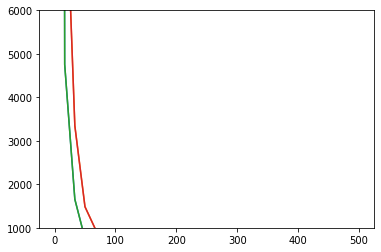

In [20]:
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 500, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
plt.plot(x, elbo_test_set)
plt.ylim(1000, 6000)

elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 500, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
plt.plot(x, elbo_test_set)
plt.ylim(1000, 6000)

In [21]:
posterior = trainer.create_posterior(
        trainer.model, data, indices=np.arange(len(data))
    ).sequential()

latent, _, _ = posterior.get_latent()


# get imputed gene expression values

In [22]:
# imputed_values = posterior.sequential().imputation()
# normalized_values = posterior.sequential().get_sample_scale()

# using scVI latent space in scanpy

In [23]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [24]:
adata.obsm["X_scvi"] = latent
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10, use_rep="X_scvi")
sc.tl.umap(adata)

sc.tl.louvain(adata, key_added="louvain_scvi", resolution=1)

In [25]:
adata.obs.columns

Index(['10X_plate', 'BA_nM', 'NovaSeqRun', 'additional_notes',
       'anatomical_position', 'barcode', 'batch', 'bead_cleanup',
       'cDNA_dilute', 'cDNA_prep_person', 'excluded', 'investigator',
       'lib_prep_date', 'library_prep', 'method', 'n_genes', 'plate',
       'primary_sort', 'sex', 'sort_direction', 'sort_order', 'subjectid',
       'tissue', 'well', 'well_group', 'louvain_scvi'],
      dtype='object')

... storing '10X_plate' as categorical
... storing 'BA_nM' as categorical
... storing 'NovaSeqRun' as categorical
... storing 'additional_notes' as categorical
... storing 'anatomical_position' as categorical
... storing 'barcode' as categorical
... storing 'bead_cleanup' as categorical
... storing 'cDNA_dilute' as categorical
... storing 'cDNA_prep_person' as categorical
... storing 'excluded' as categorical
... storing 'investigator' as categorical
... storing 'lib_prep_date' as categorical
... storing 'library_prep' as categorical
... storing 'method' as categorical
... storing 'plate' as categorical
... storing 'primary_sort' as categorical
... storing 'sex' as categorical
... storing 'sort_direction' as categorical
... storing 'sort_order' as categorical
... storing 'subjectid' as categorical
... storing 'tissue' as categorical
... storing 'well' as categorical
... storing 'well_group' as categorical


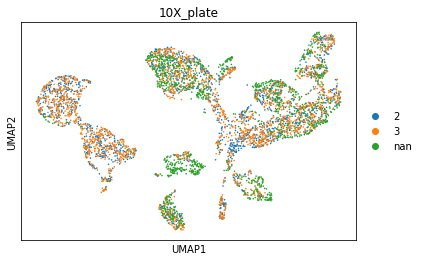

In [26]:
sc.pl.umap(adata, color=['10X_plate'],s=10)

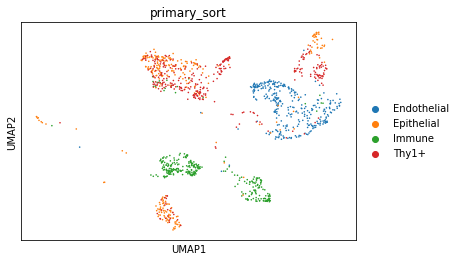

In [27]:
sc.pl.umap(adata[adata.obs['batch']==2,:], color=['primary_sort'],s=10)



# Endothelium	
|Cell type | number | marker genes|
|-----|-----|-------|
|Artery	|	|CD31, GJA5, BMX|
|Vessel	|	|	CD31, ACKR1,NR2F2|
|Capillary	|	|	CD31, CA4|
|Lymphatic|	|	PROX1, PDPN|

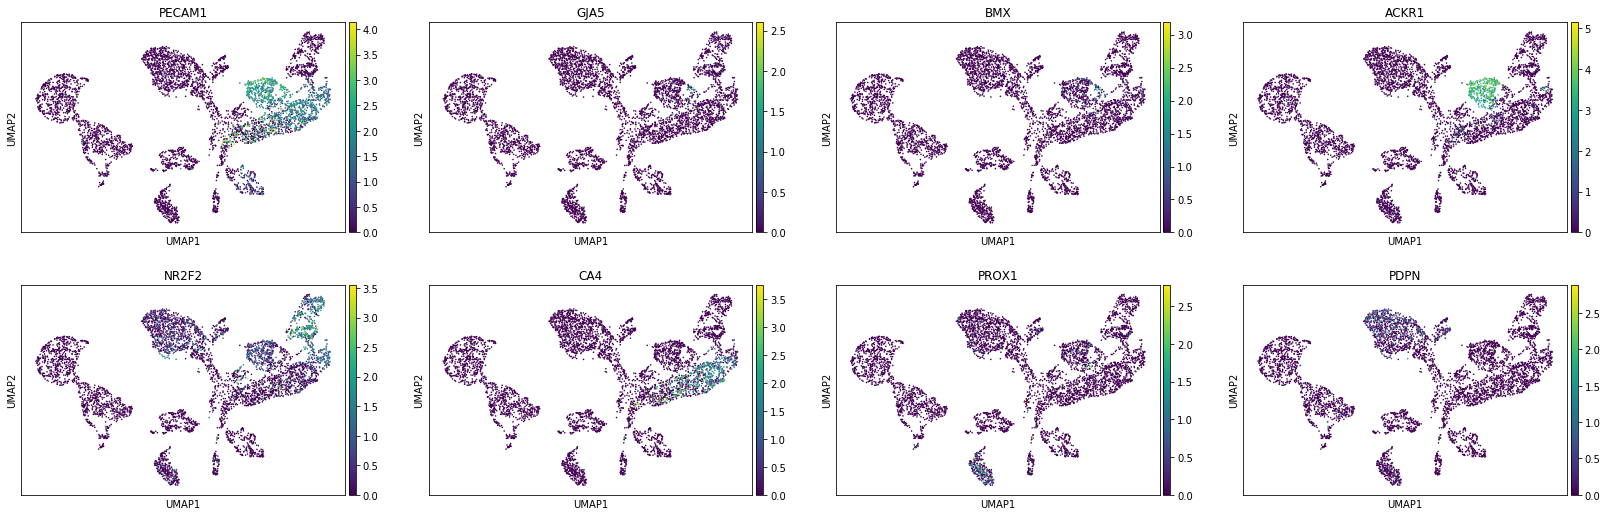

In [28]:
sc.pl.umap(adata, color=['PECAM1','GJA5' ,'BMX','ACKR1','NR2F2','CA4','PROX1','PDPN'],s=10)

# Stroma	
|Cell type | number | marker genes|
|-----|-----|-------|
|Vascular smooth muscle|	5000	|CNN1, ACTA2, TAGLN, NOTCH3, LGR5, MYH11|
|Mesenchymal stem cell|		|PDGFRA|
|Fibroblast	|1333	|	DCN, PDGFRA, SCARA5|


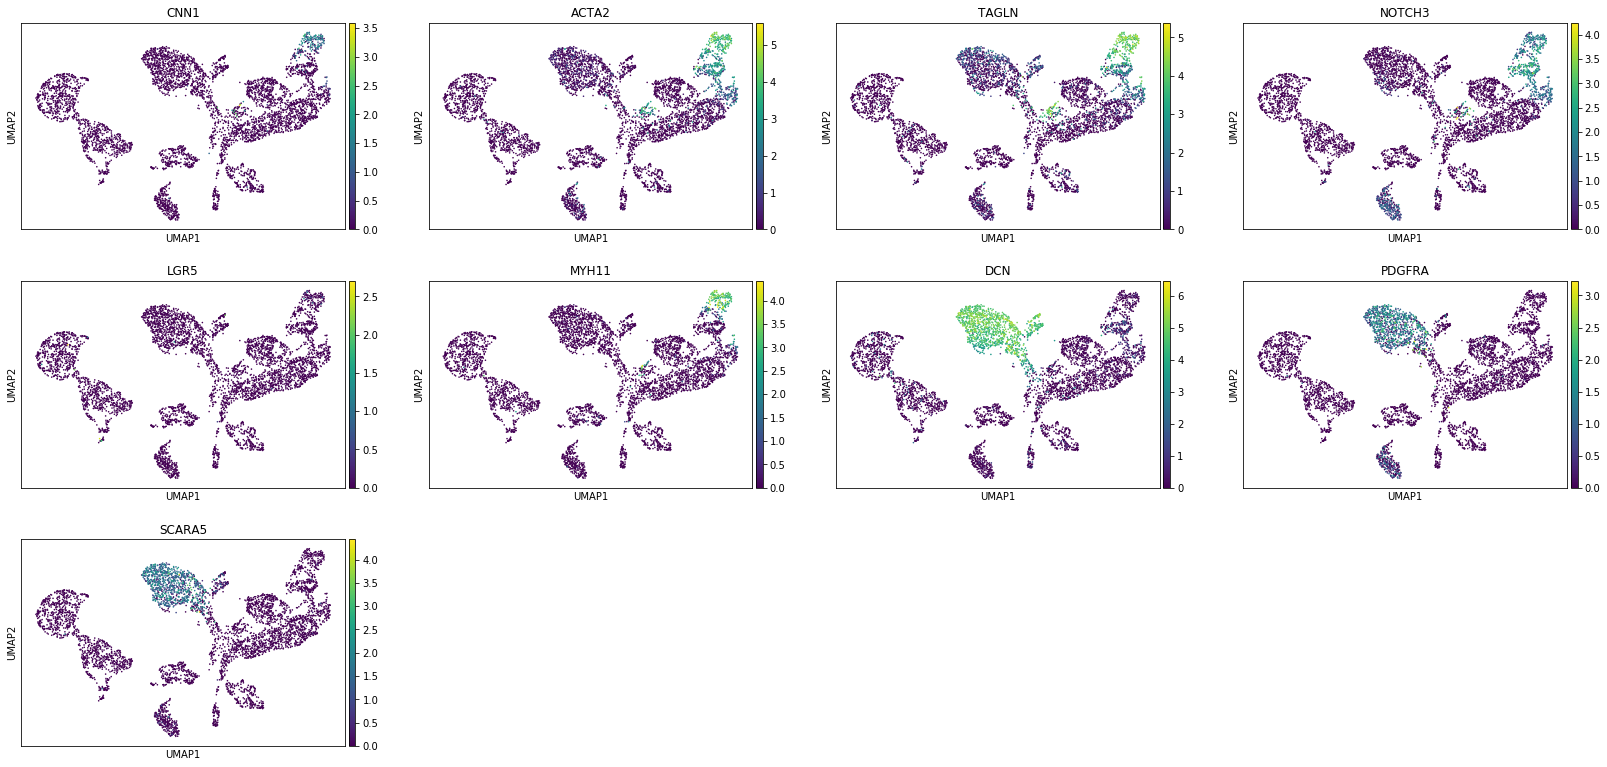

In [29]:
sc.pl.umap(adata, color=['CNN1','ACTA2' ,'TAGLN','NOTCH3','LGR5',
                         'MYH11' ,'DCN','PDGFRA','SCARA5'],s=10)

# PNS
|Cell type | number | marker genes|
|-----|-----|-------|
|Intrinsic Neuron| |SNAP25|
|Terminal glial cell| | GFAP NES|			


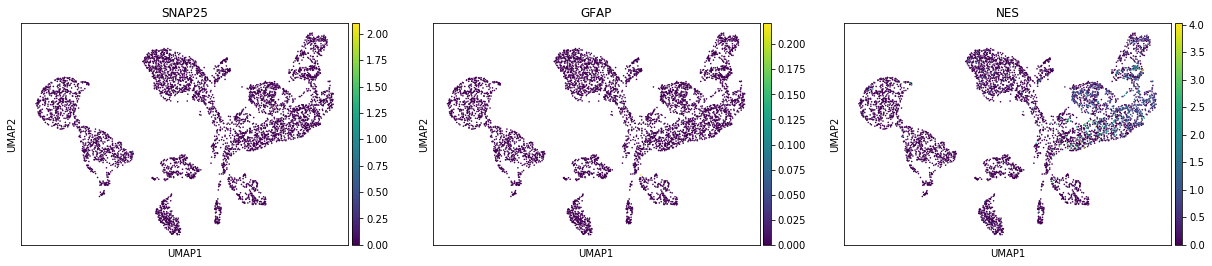

In [30]:
sc.pl.umap(adata, color=['SNAP25' ,'GFAP','NES'],s=10)

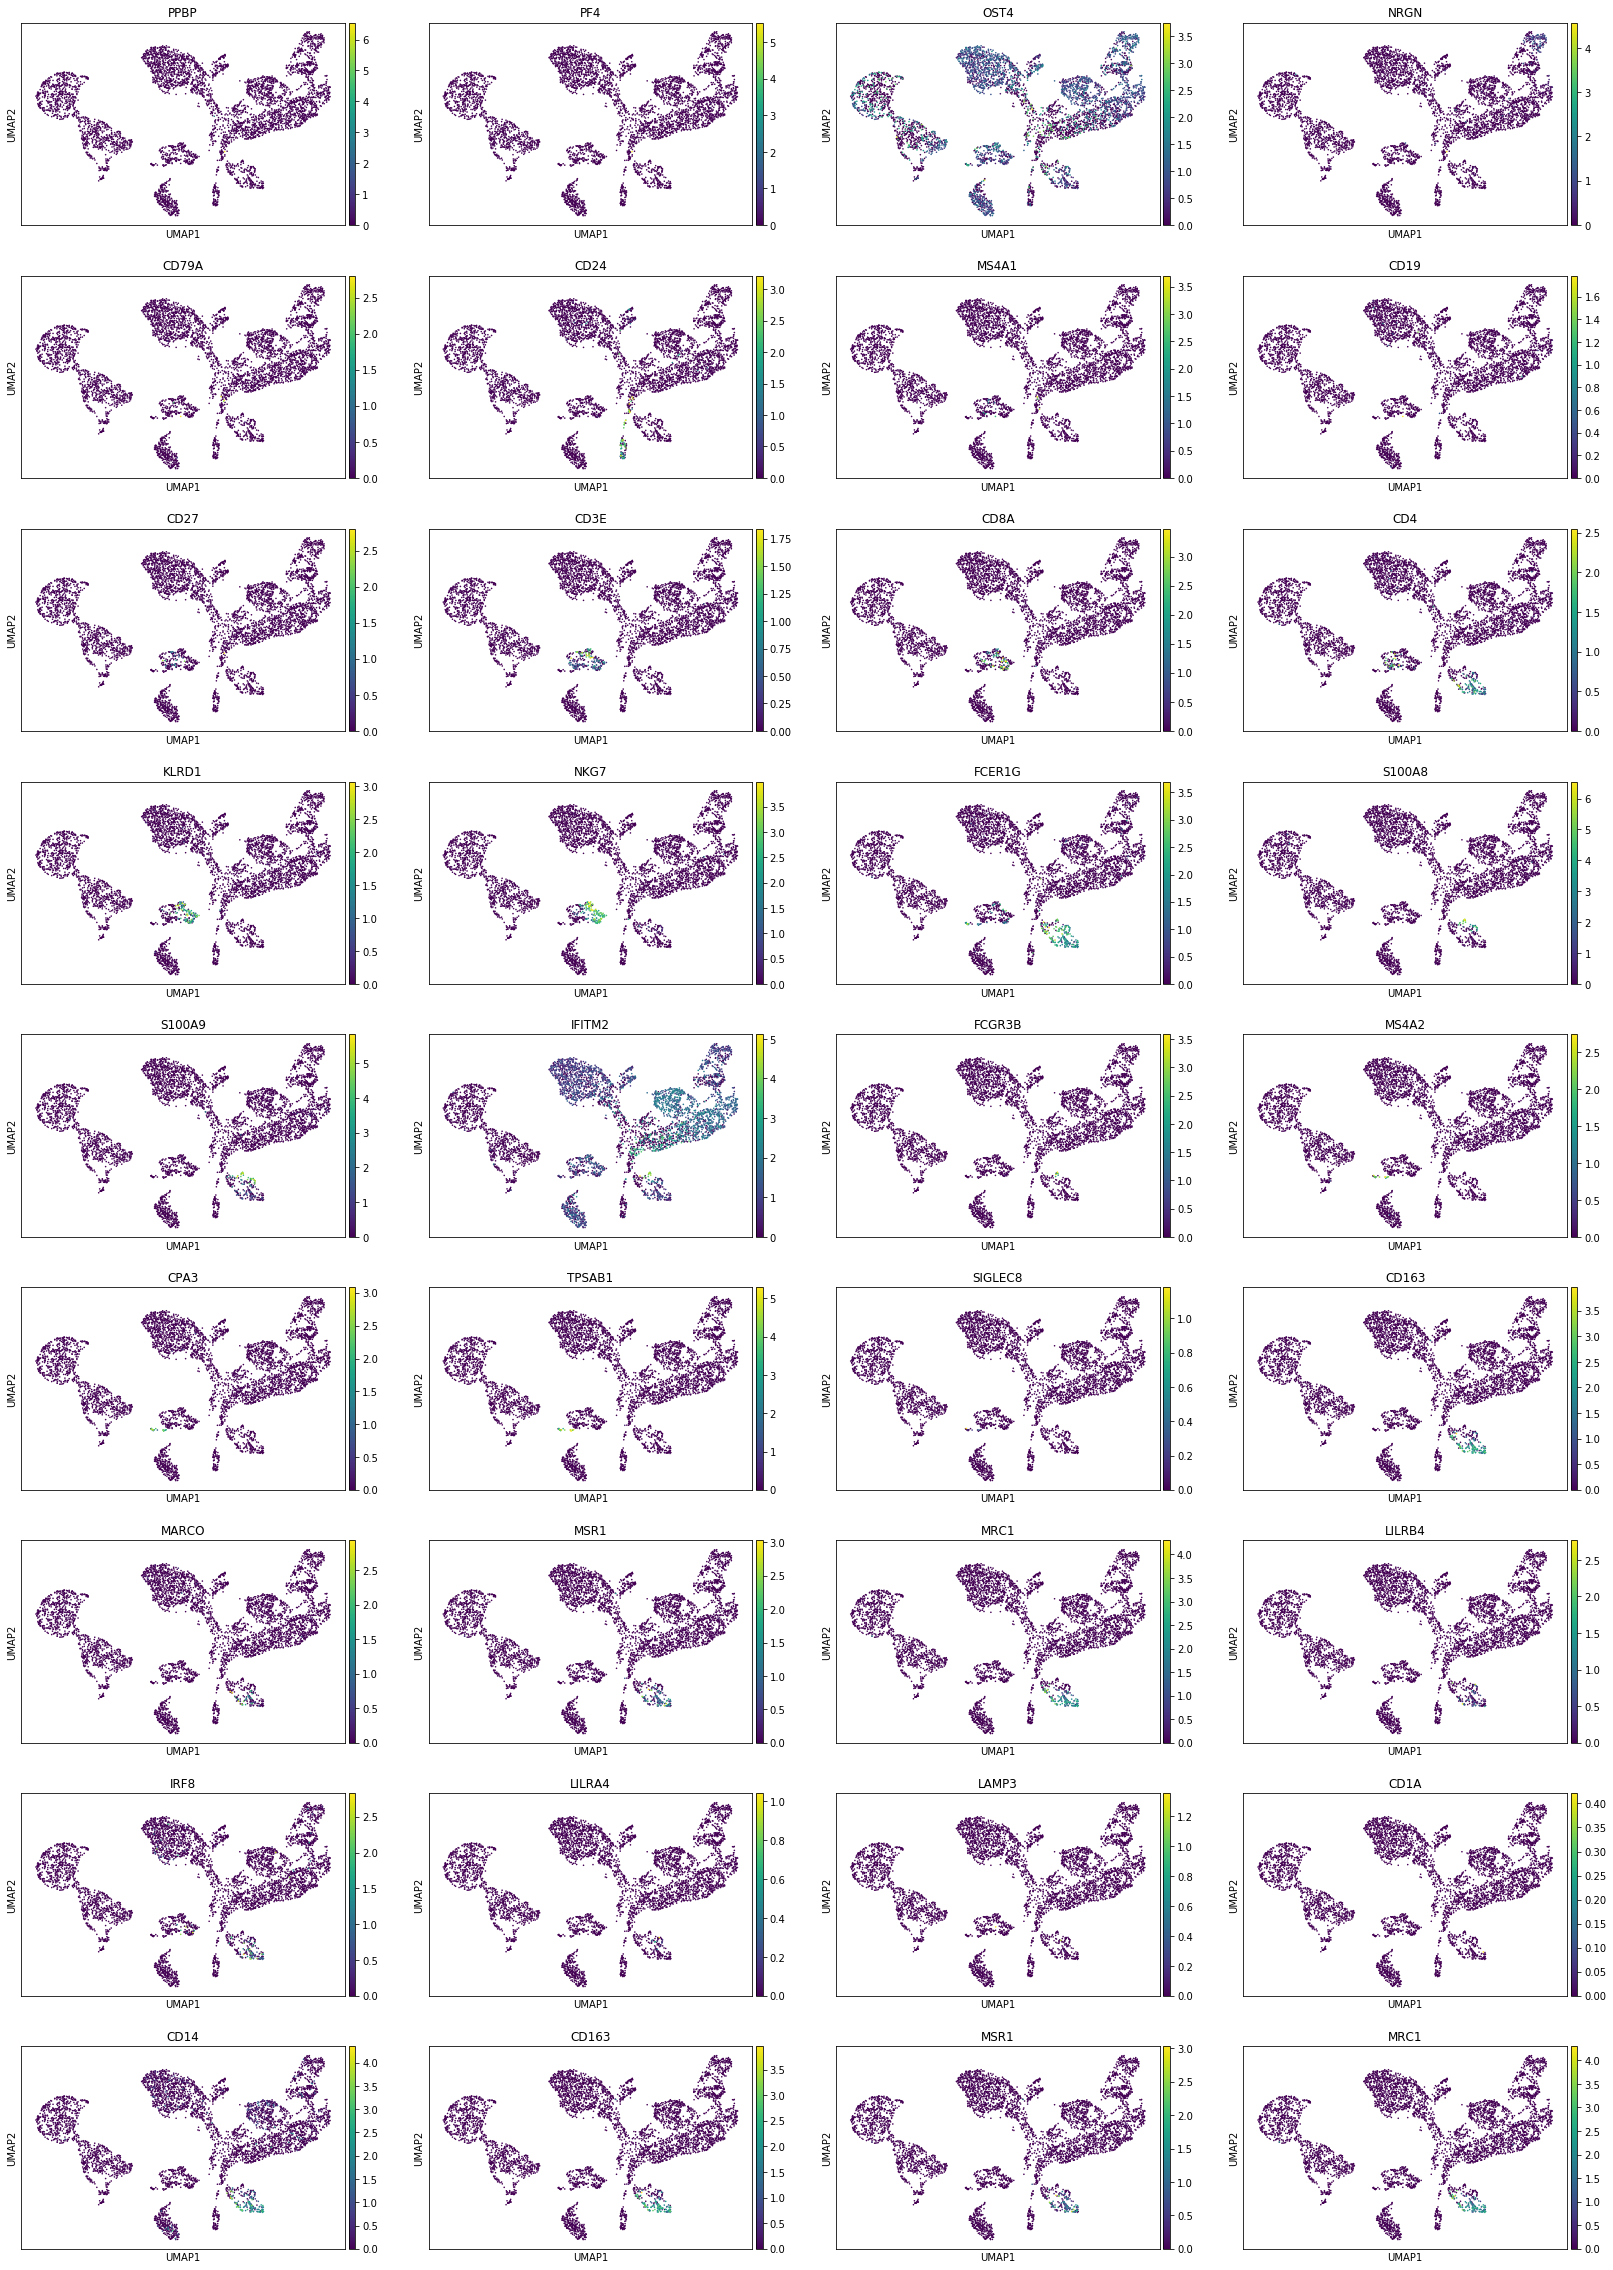

In [31]:
genelist = ['PPBP','PF4','OST4','NRGN',
            'CD79A','CD24','MS4A1','CD19',
           'CD27','CD3E','CD8A','CD4','KLRD1','NKG7','FCER1G',
           'S100A8','S100A9','IFITM2','FCGR3B',
           'MS4A2','CPA3','TPSAB1','SIGLEC8','CD163','MARCO','MSR1','MRC1',
           'LILRB4','IRF8','LILRA4','LAMP3','CD1A','CD14',
           'CD163','MSR1','MRC1']
sc.pl.umap(adata, color=genelist,s=10)

Pax7,Myod1
Scx
Dmd, Ttn
Des


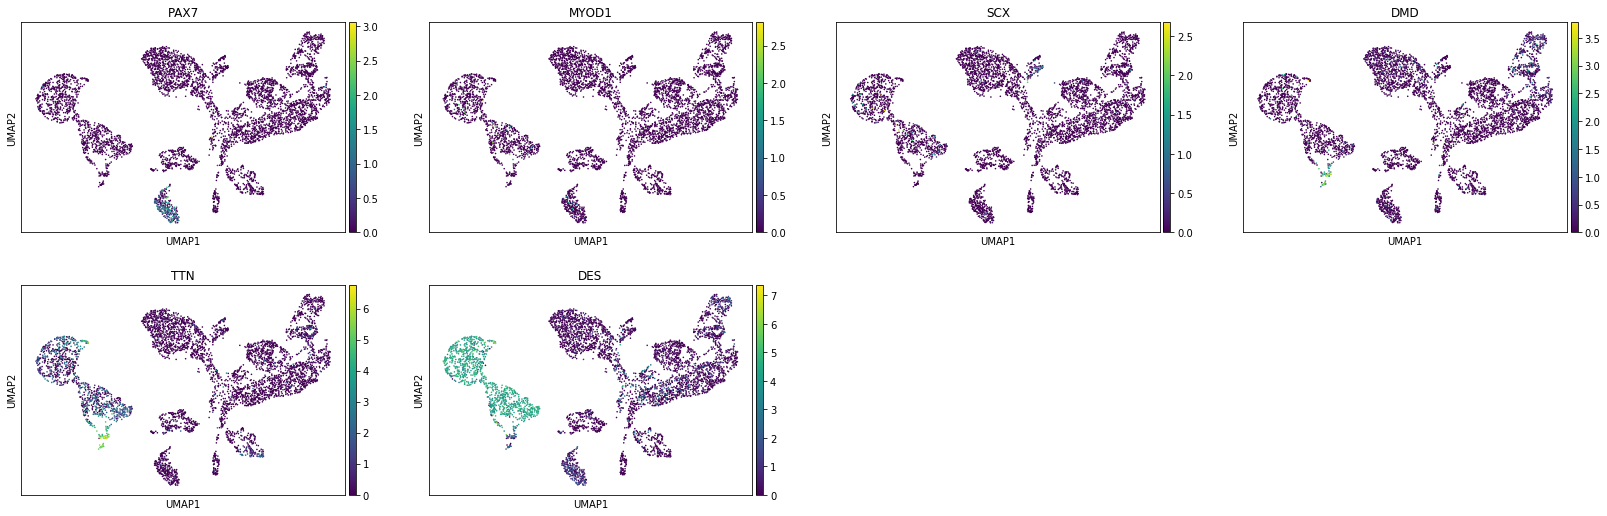

In [32]:
genelist = ['PAX7','MYOD1','SCX',
           'DMD',"TTN",'DES']
sc.pl.umap(adata, color=genelist,s=10)

# use scANVI to split compartment, then perform leiden clustering on each compartment

In [33]:
data.cell_types, data.labels = np.unique(adata.obs['primary_sort'].values, return_inverse=True)
data.labels = data.labels.reshape(len(data.labels),1)
data.n_labels = len(data.cell_types)

In [34]:
data.cell_types

array(['Endothelial', 'Epithelial', 'Immune', 'Thy1+', 'nan'],
      dtype=object)

In [35]:
np.unique(data.batch_indices,return_counts=True)

(array([0, 1, 2], dtype=uint16), array([1753, 2012, 1272]))

In [36]:
np.unique(data.batch_indices.ravel()[data.labels.ravel()==4],return_counts=True)

(array([0, 1], dtype=uint16), array([1753, 2012]))

In [37]:
scanvi = SCANVI(data.nb_genes, data.n_batches, data.n_labels, n_layers=2,n_latent=10)
scanvi.load_state_dict(posterior.model.state_dict(), strict=False)
trainer_scanvi = AlternateSemiSupervisedTrainer(scanvi, data, classification_ratio=0,
                                                n_epochs_classifier=100, lr_classification=5 * 1e-3)

nan_idx = list(data.cell_types).index('nan')
islabelled = np.logical_and((data.batch_indices.ravel() == 2), data.labels.ravel()!= nan_idx )
notlabelled = np.logical_or((data.batch_indices.ravel() == 0), data.labels.ravel()== nan_idx )

labelled = np.where(islabelled)[0]
labelled = np.random.choice(labelled, len(labelled), replace=False)
trainer_scanvi.labelled_set = trainer_scanvi.create_posterior(indices=labelled)
trainer_scanvi.unlabelled_set = trainer_scanvi.create_posterior(indices=notlabelled)
trainer_scanvi.train(n_epochs=3)

full = trainer_scanvi.create_posterior(trainer_scanvi.model, data, indices=np.arange(len(data)))
_, labels_pred = full.sequential().compute_predictions()

In [38]:
np.sum(islabelled)

1272

In [39]:
np.unique(data.batch_indices.ravel()[islabelled],return_counts=True)

(array([2], dtype=uint16), array([1272]))

In [40]:
np.unique(data.labels.ravel(),return_counts=True)

(array([0, 1, 2, 3, 4], dtype=uint16), array([ 319,  293,  327,  333, 3765]))

In [41]:
np.unique(data.labels.ravel()[(data.batch_indices.ravel() == 0)])

array([4], dtype=uint16)

In [42]:
 data.cell_types

array(['Endothelial', 'Epithelial', 'Immune', 'Thy1+', 'nan'],
      dtype=object)

In [43]:
adata.obs['compartment_pred'] = data.cell_types[labels_pred]

# color by predicted compartments

... storing 'compartment_pred' as categorical


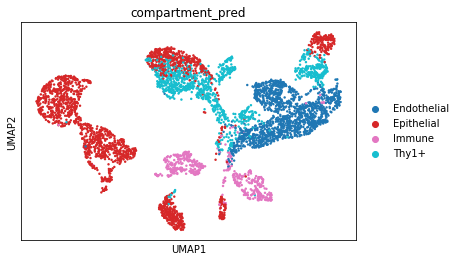

In [44]:
sc.pl.umap(adata, color=['compartment_pred'],palette = 'tab10',ncols=1)

# seed labeling with compartment markers

In [62]:
compartments = {'Epithelial':['EPCAM', 'CDH1'], 
                'Endothelial':['LYVE1','CLDN5','CDH5','VWF','CA4'],
                'Stromal':['ACTA2' ,'DCN','PDGFRA'],
               'Immune':['PTPRC','RAC2','LCP1'] ,
               'Pancreas':['CELA3A'],
               'Muscle':["TTN",'DES']}

In [63]:
for x in compartments.keys():
    sc.tl.score_genes(adata, ctrl_size=100, gene_list=compartments[x],score_name = x)

... storing 'Epithelial_label' as categorical
... storing 'Endothelial_label' as categorical
... storing 'Stromal_label' as categorical
... storing 'Immune_label' as categorical
... storing 'PNS_label' as categorical
... storing 'Pancreas_label' as categorical
... storing 'Muscle_label' as categorical


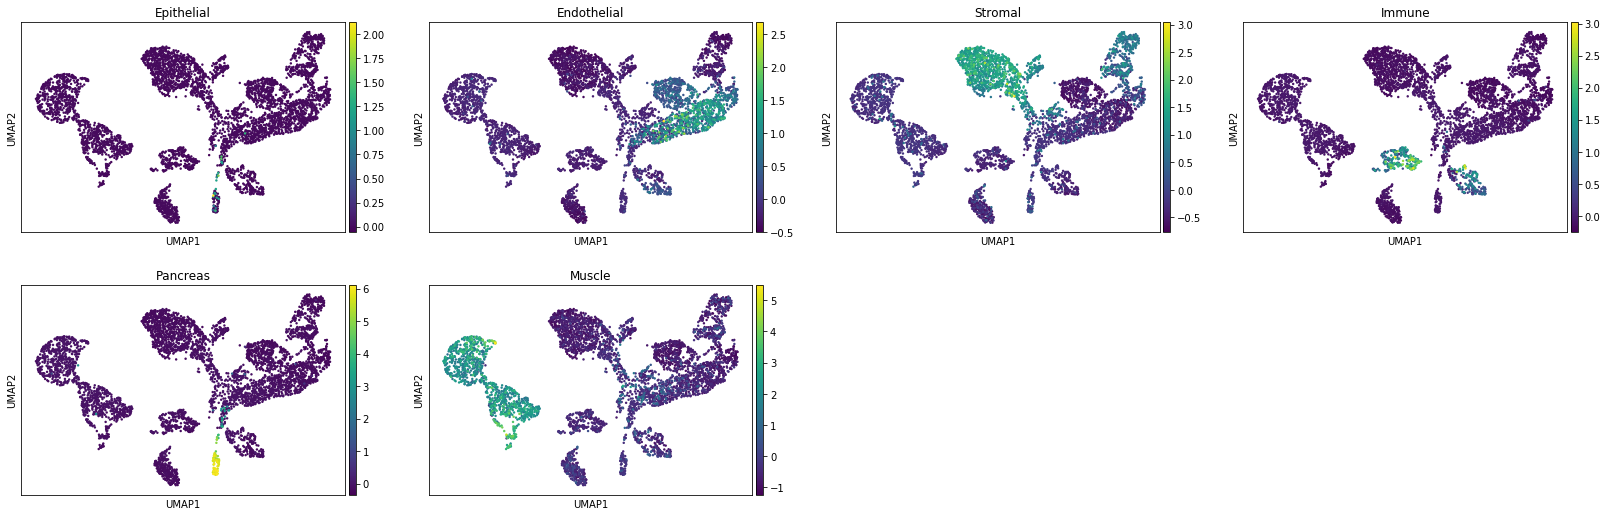

In [64]:
sc.pl.umap(adata, color=compartments.keys())

In [65]:
for x in compartments.keys():
    indicator = x+'_label'
    # compute gene signature scores
    sc.tl.score_genes(adata, compartments[x], score_name=x)
    cutoff = np.min(adata.obs.nlargest(500,x)[x].values)
    if x=='Pancreas':
        cutoff = np.min(adata.obs.nlargest(50,x)[x].values)
    if x=='Endothelial' or x=='Muscle':
        cutoff = np.min(adata.obs.nlargest(100,x)[x].values)
    adata.obs[indicator] = (adata.obs[x].values>cutoff).astype(str)


... storing 'Epithelial_label' as categorical
... storing 'Endothelial_label' as categorical
... storing 'Stromal_label' as categorical
... storing 'Immune_label' as categorical
... storing 'Pancreas_label' as categorical
... storing 'Muscle_label' as categorical


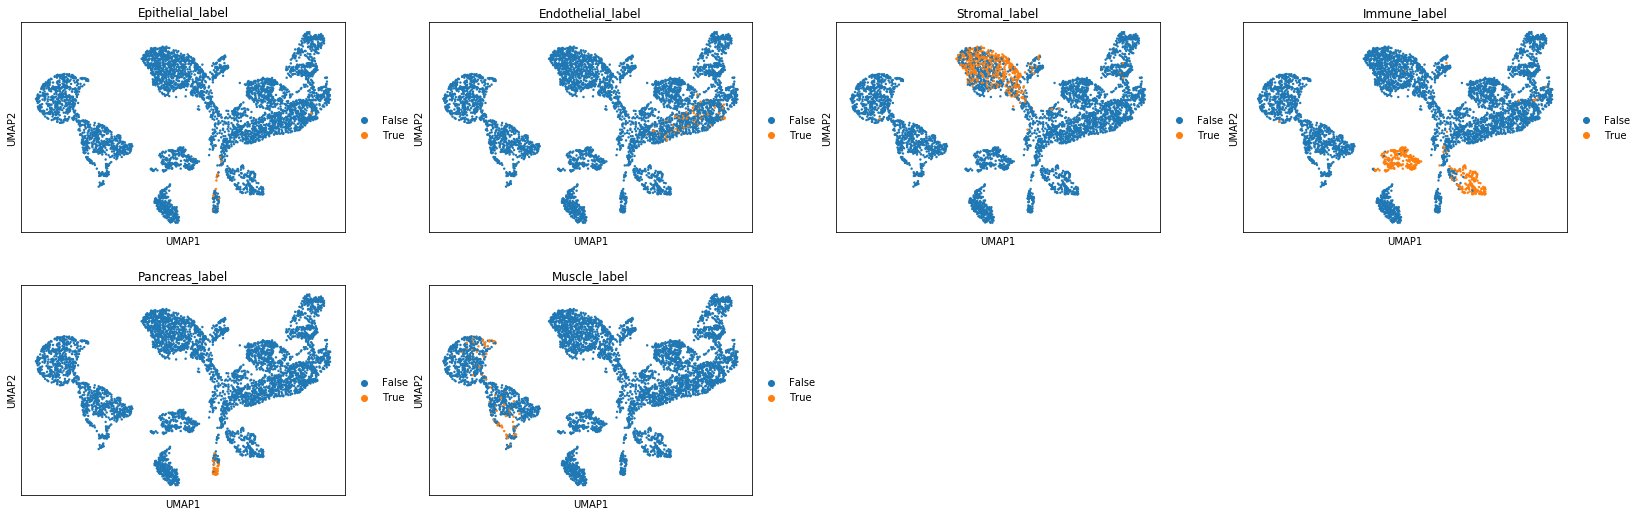

In [66]:
labelled = [x+'_label' for x in compartments.keys()]
sc.pl.umap(adata, color=labelled)

In [67]:
all_indicators = pd.concat([adata.obs[x+'_label'] for x in compartments.keys()], axis = 1)
unique_celltypes = ((all_indicators.values=='True').sum(axis=1) <=1 )

labels = np.repeat(0, data.X.shape[0])
for i, c in enumerate(compartments.keys()):
    idx = np.where(
        np.logical_and(
        unique_celltypes, 
        adata.obs[c+'_label'].values=='True'))[0]
    labels[idx] = i+1

data.cell_types = ['unlabelled']+list(compartments.keys())
data.labels = labels.reshape(len(labels),1)
data.n_labels = len(data.cell_types)

labelled = np.where(data.labels.ravel()!=0)[0]
labelled = np.random.choice(labelled, len(labelled), replace=False)

unlabelled = np.where(data.labels.ravel()==0)[0]
unlabelled = np.random.choice(unlabelled, len(unlabelled), replace=False)


In [68]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([3849,   20,   98,  499,  430,   42,   99]))

In [71]:

labels_pred = []
scanvi = SCANVI(data.nb_genes, data.n_batches, data.n_labels, n_layers=2,n_latent=10, symmetric_kl=True)
filename = '%s/vae.%s10xfacs.pkl'%(save_path,tissue)
scanvi.load_state_dict(torch.load(filename), strict=False)
trainer_scanvi = AlternateSemiSupervisedTrainer(scanvi, data, n_epochs_classifier=50, lr_classification=5 * 1e-3)

trainer_scanvi.labelled_set = trainer_scanvi.create_posterior(indices=labelled)
trainer_scanvi.unlabelled_set = trainer_scanvi.create_posterior(indices=unlabelled)
trainer_scanvi.train(n_epochs=15)
full = trainer_scanvi.create_posterior(trainer_scanvi.model, data, indices=np.arange(len(data)))
_, pred = full.sequential().compute_predictions()

... storing 'comp_pred' as categorical


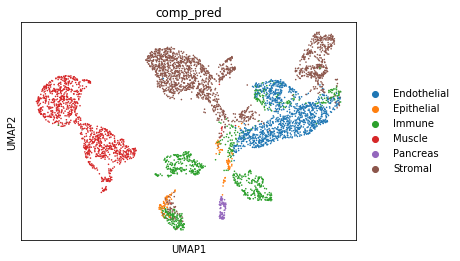

In [72]:
adata.obs['comp_pred'] = [data.cell_types[i] for i in pred]
sc.pl.umap(adata, color=['comp_pred'],  show=show_plot,size=10)

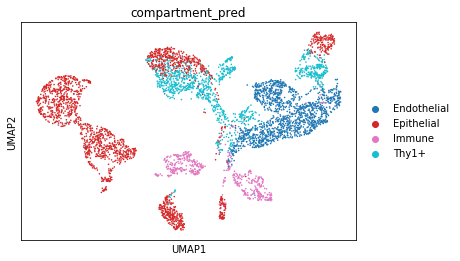

In [73]:
sc.pl.umap(adata, color=['compartment_pred'],  show=show_plot,size=10)

# plotting cell cycle changes

In [74]:
g1s_genes =  ['MCM5','PCNA','TYMS','FEN1','MCM2','MCM4','RRM1','UNG','GINS2','MCM6','CDCA7','DTL','PRIM1','UHRF1','MLF1IP','HELLS','RFC2','RPA2','NASP',
         'RAD51AP1','GMNN','WDR76','SLBP','CCNE2','UBR7','POLD3','MSH2','ATAD2','RAD51','RRM2','CDC45','CDC6','EXO1','TIPIN','DSCC1','BLM','CASP8AP2',
         'USP1','CLSPN','POLA1','CHAF1B','BRIP1','E2F8']

g2m_genes = ['HMGB2','CDK1','NUSAP1','UBE2C','BIRC5','TPX2','TOP2A','NDC80','CKS2','NUF2','CKS1B','MKI67','TMPO','CENPF','TACC3','FAM64A','SMC4','CCNB2',
        'CKAP2L','CKAP2','AURKB','BUB1','KIF11','ANP32E','TUBB4B','GTSE1','KIF20B','HJURP','HJURP','CDCA3','HN1','CDC20','TTK','CDC25C','KIF2C',
        'RANGAP1','NCAPD2','DLGAP5','CDCA2','CDCA8','ECT2','KIF23','HMMR','AURKA','PSRC1','ANLN','LBR','CKAP5','CENPE','CTCF','NEK2','G2E3','GAS2L3',
        'CBX5','CENPA']


In [75]:
sc.tl.score_genes_cell_cycle(adata, s_genes=g1s_genes, g2m_genes=g2m_genes)


... storing 'phase' as categorical


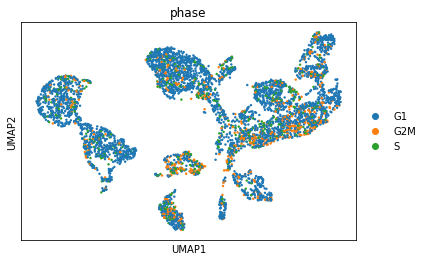

In [76]:
sc.pl.umap(adata,color=['phase'])

# differential expression

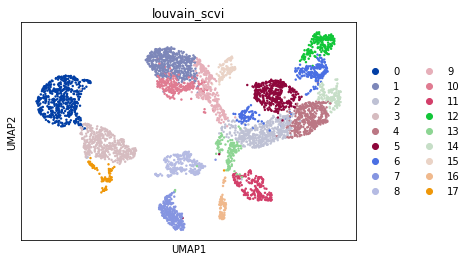

In [77]:
sc.pl.umap(adata, color=['louvain_scvi'],ncols=1)

In [78]:
sc.tl.rank_genes_groups(
    adata,
    "louvain_scvi",
    method="wilcoxon",
    use_raw=False,
    key_added="rank_genes_groups_wilcox",
    n_genes=adata.shape[1],
)

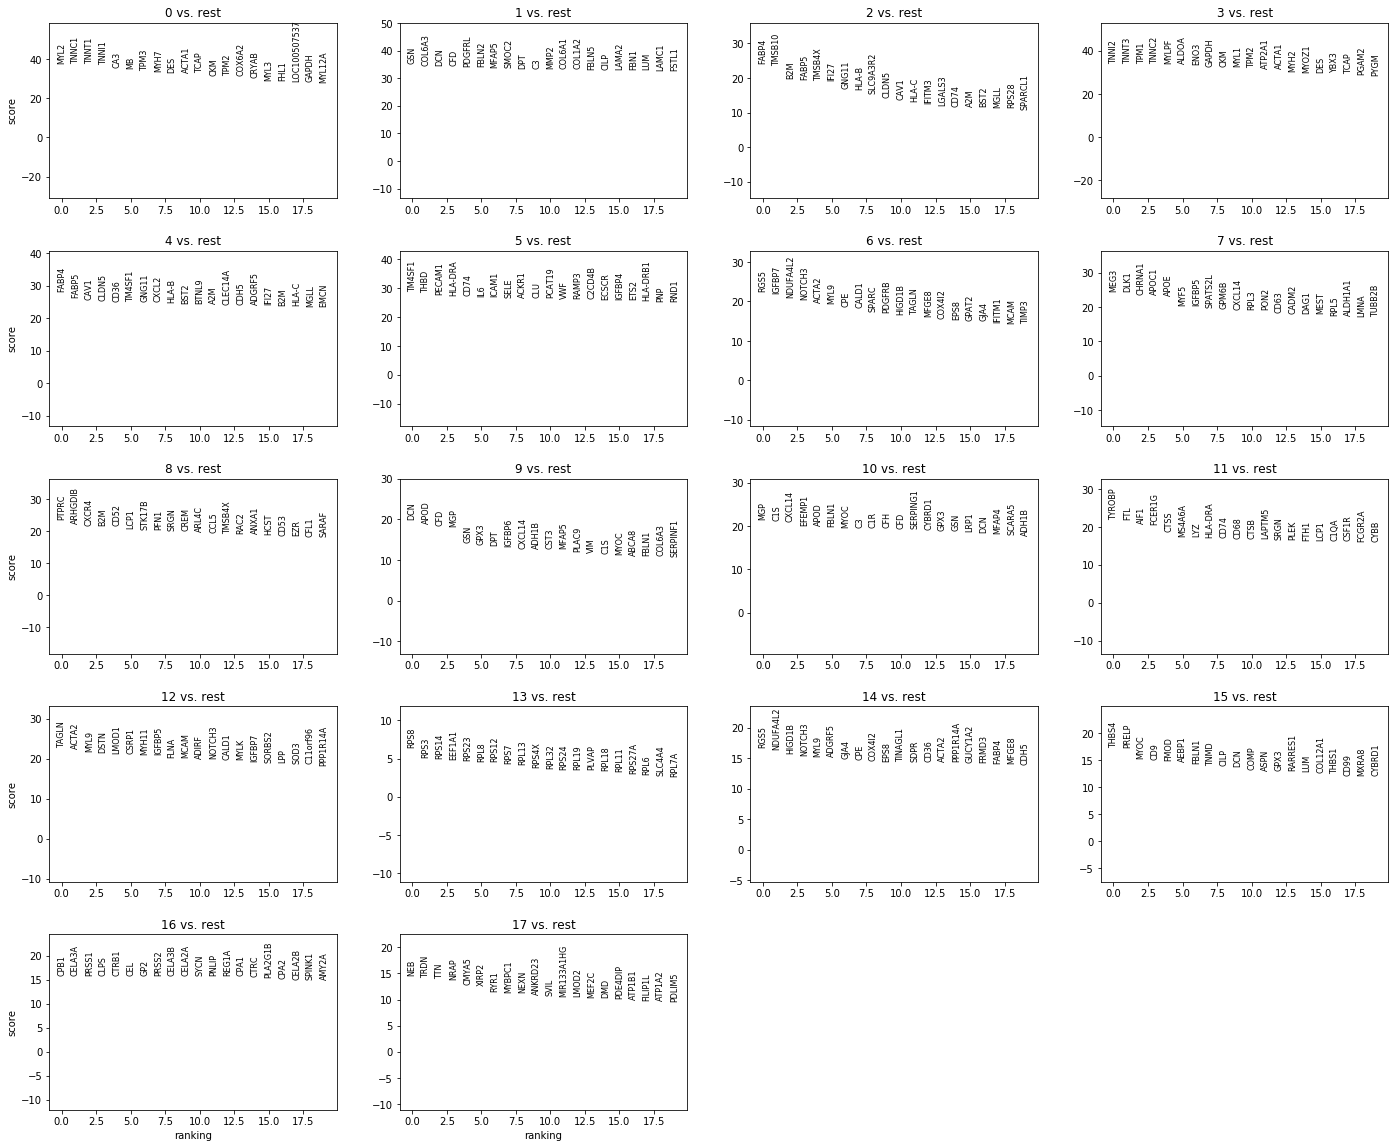

In [79]:
sc.pl.rank_genes_groups(
    adata, key="rank_genes_groups_wilcox", sharey=False
)

In [80]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
result = adata.uns['rank_genes_groups_wilcox']
groups = result['names'].dtype.names
sapiens_rank_genes_scores = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores','pvals']})
sapiens_rank_genes_scores.to_csv('%s.wilcoxon.csv'%tissue)

In [81]:
sapiens_rank_genes_scores

0_n        0_s            0_p           1_n        1_s            1_p           2_n        2_s            2_p           3_n        3_s            3_p        4_n        4_s            4_p           5_n        5_s            5_p        6_n        6_s            6_p           7_n        7_s            7_p           8_n        8_s            8_p        9_n        9_s           9_p          10_n       10_s           10_p        11_n       11_s           11_p        12_n       12_s           12_p          13_n       13_s          13_p          14_n       14_s          14_p           15_n       15_s          15_p          16_n       16_s          16_p         17_n       17_s          17_p
0              MYL2  38.100506   0.000000e+00           GSN  35.527073  1.877835e-276         FABP4  24.332247  8.937586e-131         TNNI2  34.286343  1.254023e-257      FABP4  28.410297  1.508747e-177        TM4SF1  29.040758  2.013239e-185       RGS5  22.648928  1.429459e-113          MEG3  24.672289  2.122047e-134         PTPRC  23.743084  1.295205e-124        DCN  20.074856  1.224351e-89           MGP  21.644848  6.796732e-104      TYROBP  22.100887  3.099116e-108       TAGLN  22.912128  3.517379e-116          RPS8   6.512115  7.410016e-11          RGS5  16.828735  1.502795e-63          THBS4  17.449617  3.465470e-68          CPB1  16.013702  1.025232e-57          NEB  14.711715  5.421597e-49
1             TNNC1  38.090240   0.000000e+00        COL6A3  34.854584  3.628600e-266        TMSB10  23.569113  7.995902e-123         TNNT3  34.239185  6.318143e-257      FABP5  26.379955  2.327268e-153          THBD  28.585644  1.013389e-179     IGFBP7  21.970623  5.500926e-107          DLK1  24.573217  2.443014e-133       ARHGDIB  22.411900  3.013117e-111       APOD  18.895094  1.251626e-79           C1S  21.233126  4.721572e-100         FTL  22.020357  1.838062e-107       ACTA2  22.545803  1.476411e-112          RPS3   5.202312  1.968244e-07      NDUFA4L2  16.465570  6.484891e-61          PRELP  17.325321  3.029966e-67        CELA3A  16.013628  1.026458e-57         TRDN  14.167352  1.458989e-45
2             TNNT1  38.024982   0.000000e+00           DCN  34.827938  9.188897e-266           B2M  19.780815   4.355890e-87          TPM1  34.091671  9.801083e-255       CAV1  25.946457  1.993624e-148        PECAM1  27.967457  4.043909e-172   NDUFA4L2  21.111784   6.198832e-99        CHRNA1  23.626892  2.040104e-123         CXCR4  21.817062  1.598003e-105        CFD  18.612911  2.525206e-77        CXCL14  20.976292   1.079959e-97        AIF1  20.941618   2.237271e-97        MYL9  21.706184  1.793445e-104         RPS14   5.073551  3.904599e-07        HIGD1B  15.725242  1.015626e-55           MYOC  15.336691  4.348034e-53         PRSS1  16.013628  1.026458e-57          TTN  14.017538  1.217663e-44
3             TNNI1  37.511738  5.928826e-308           CFD  34.817516  1.321258e-265         FABP5  19.744612   8.924739e-87         TNNC2  34.032402  7.392273e-254      CLDN5  25.522764  1.101887e-143       HLA-DRA  27.560282  3.332361e-167     NOTCH3  20.442131   7.058898e-93         APOC1  23.584368  5.576721e-123           B2M  21.719332  1.347267e-104        MGP  18.248751  2.116980e-74        EFEMP1  20.194277   1.099224e-90      FCER1G  20.731462   1.802264e-95        DSTN  21.650194  6.052467e-104        EEF1A1   4.914198  8.914641e-07        NOTCH3  15.381074  2.192810e-53            CD9  15.194850  3.825399e-52          CLPS  16.013107  1.035085e-57         NRAP  13.772841  3.713167e-43
4               CA3  36.007866  6.300372e-284        PDGFRL  34.253208  3.907377e-257        TMSB4X  19.296244   5.775757e-83         MYLPF  33.990208  3.108569e-253       CD36  25.292816  3.831924e-141          CD74  27.443594  8.284948e-166      ACTA2  19.848783   1.129019e-87          APOE  23.300230  4.409581e-120          CD52  21.682232  3.018798e-104        GSN  14.189511  1.063978e-45          APOD  20.075228   1.215221e-89        CTSS  18.926350   6.919413e-80       L

In [82]:
adata.write('%s.scVI.h5ad'%tissue)